<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_02_imbalanced_data_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Class Imbalance in Machine Learning

**Class imbalance** refers to a situation in a classification problem where the number of instances in different classes is significantly disproportionate. In other words, one class (the majority class) has many more instances than the other class (the minority class).

#### Key Points about Class Imbalance:

1. **Prevalence**:
   - Class imbalance is common in many real-world datasets. Examples include fraud detection (where fraudulent transactions are rare), medical diagnosis (where certain diseases have low prevalence), and spam detection (where spam emails are much fewer than legitimate ones).

2. **Impact on Model Performance**:
   - **Bias Toward Majority Class**: Many machine learning algorithms assume that the classes are balanced. When they are not, the model may become biased toward the majority class, resulting in high accuracy but poor performance on the minority class.
   - **Misleading Metrics**: Accuracy becomes a misleading metric in imbalanced datasets. A model that always predicts the majority class can achieve high accuracy but fails to correctly identify the minority class.
   - **Poor Generalization**: The model might fail to generalize well to unseen data, especially in correctly identifying instances of the minority class.

3. **Performance Metrics for Imbalanced Data**:
   - **Precision**: The proportion of true positives among all predicted positives. Useful when the cost of false positives is high.
   - **Recall (Sensitivity)**: The proportion of true positives among all actual positives. Useful when the cost of false negatives is high.
   - **F1 Score**: The harmonic mean of precision and recall. Provides a balanced measure, especially useful for imbalanced datasets.
   - **ROC-AUC**: Measures the ability of the model to distinguish between classes. The area under the ROC curve (AUC) provides an aggregate measure of performance across all classification thresholds.
   - **Precision-Recall AUC**: Particularly useful for highly imbalanced datasets, focusing on the performance with respect to the minority class.

4. **Techniques to Address Class Imbalance**:
   - **Resampling Techniques**:
     - **Oversampling**: Increasing the number of instances in the minority class. Techniques include Random Oversampling and Synthetic Minority Over-sampling Technique (SMOTE).
     - **Undersampling**: Reducing the number of instances in the majority class. Techniques include Random Undersampling and NearMiss.
   - **Algorithmic Approaches**:
     - **Cost-sensitive Learning**: Assigning different misclassification costs to classes, penalizing the misclassification of the minority class more heavily.
     - **Anomaly Detection Models**: Treating the minority class as anomalies and using specialized models designed for anomaly detection.
   - **Ensemble Methods**:
     - **Balanced Random Forest**: Combining multiple decision trees with resampling to create balanced datasets for each tree.
     - **EasyEnsemble and BalanceCascade**: Combining boosting with undersampling techniques.

5. **Threshold Adjustment**:
   - Adjusting the decision threshold of the classifier to better capture the minority class. For example, lowering the threshold can increase the recall for the minority class at the expense of precision.



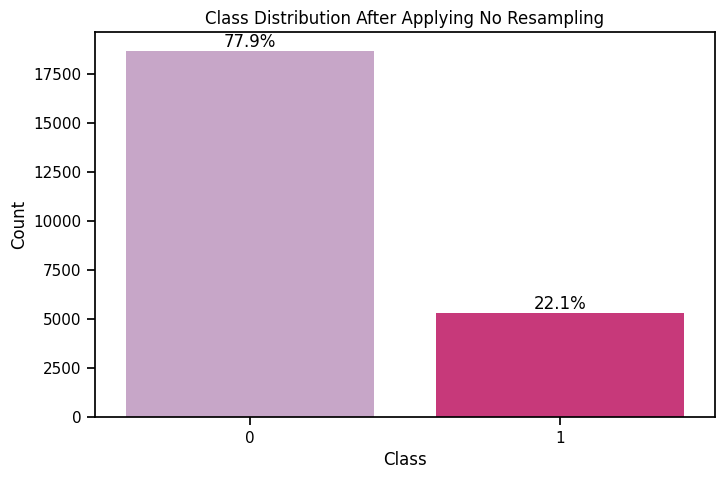

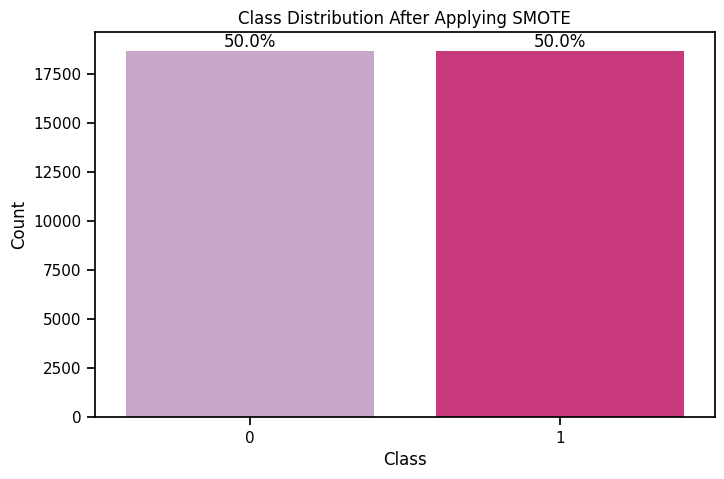

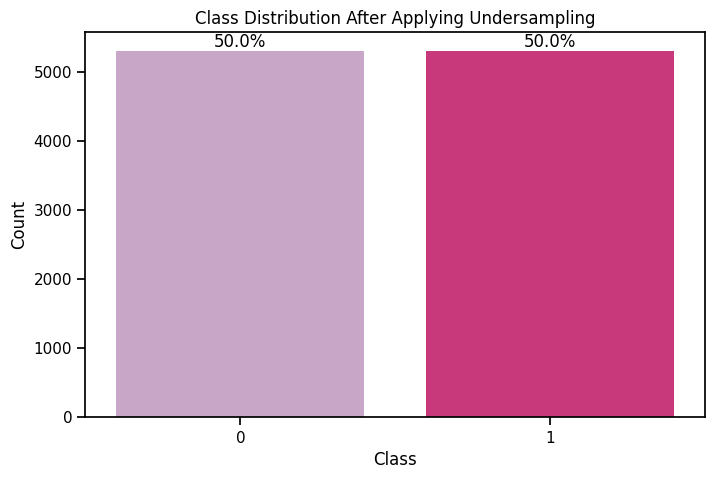

<Figure size 1200x800 with 0 Axes>

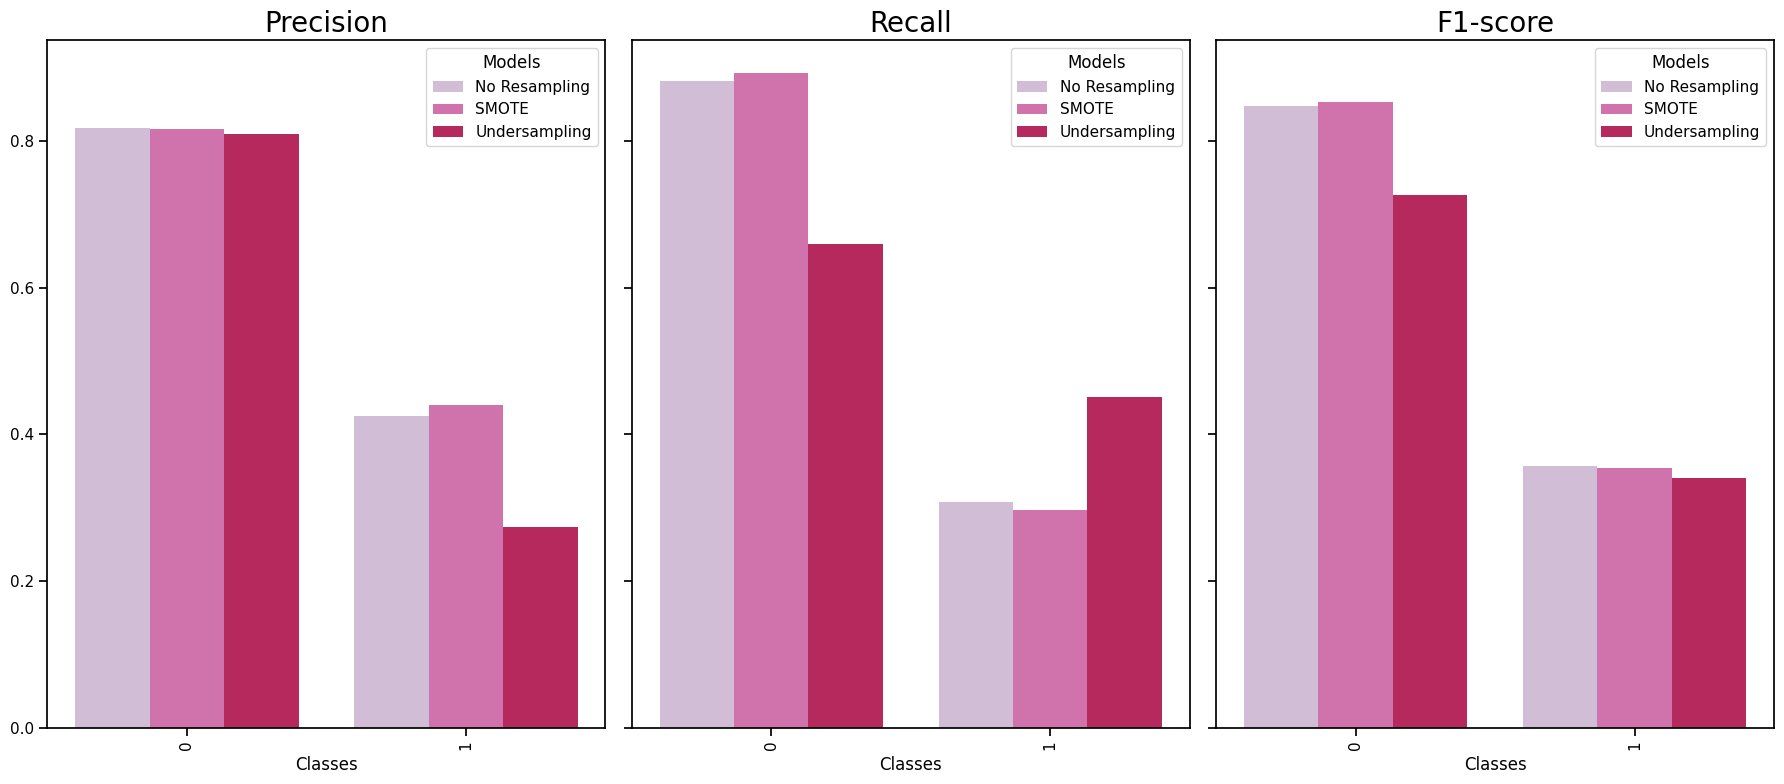

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from model_pipeline import SklearnSimpleNN, train_model
import torch

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Generalized function to plot class distribution after sampling
def plot_class_distribution_after_sampling(y_train_res, sampling_type):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train_res, hue=y_train_res, palette='PuRd', dodge=False, legend=False)
    plt.title(f'Class Distribution After Applying {sampling_type}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train_res)
    class_counts = y_train_res.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    input_dim = X_train.shape[1]
    if class_weights is None:
        class_weights = [1.0, 1.0]

    nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train, y_train)
    y_pred = nn_estimator.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

# Function to plot multiple classification reports
def plot_multiple_classification_reports(y_trues, y_preds, model_names, metrics=['precision', 'recall', 'f1-score'], palette="PuRd"):
    reports = []
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        # Generate classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        # Drop the non-class rows
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
        report_df['model'] = model_name
        reports.append(report_df)

    # Combine all reports into a single DataFrame
    combined_report = pd.concat(reports).reset_index().rename(columns={'index': 'class'})

    # Plot the results for each metric
    sns.set_context('notebook')
    plt.figure(figsize=(12, 8))
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=combined_report, x='class', y=metric, hue='model', palette=palette, ax=ax)
        ax.set_title(f'{metric.capitalize()}', fontsize=20)
        ax.set_xlabel('Classes')
        # ax.set_ylabel(metric.capitalize())
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title='Models', loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to apply resampling and plot class distribution
def apply_resampling_and_plot(X_train, y_train):
    # No Resampling
    plot_class_distribution_after_sampling(y_train, "No Resampling")

    # Apply SMOTE
    X_train_smote, y_train_smote = apply_smote(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_smote, "SMOTE")

    # Apply Undersampling
    X_train_under, y_train_under = apply_undersampling(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_under, "Undersampling")

    return (X_train, y_train), (X_train_smote, y_train_smote), (X_train_under, y_train_under)

# Function to train and evaluate models
def train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test):
    reports = []
    y_preds = []

    for X_train, y_train in zip(X_train_sets, y_train_sets):
        X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
        X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)
        report, y_pred = train_and_evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
        reports.append(report)
        y_preds.append(y_pred)

    return reports, y_preds

# Function to gather reports and predictions into DataFrame
def gather_reports_and_predictions(reports, y_trues, y_preds, model_names):
    combined_report = pd.concat(
        [pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore').assign(model=model_name) for report, model_name in zip(reports, model_names)]
    ).reset_index().rename(columns={'index': 'class'})

    return combined_report

# Main function to load data and call other functions
def main(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Apply resampling and plot class distribution
    (X_train, y_train), (X_train_smote, y_train_smote), (X_train_under, y_train_under) = apply_resampling_and_plot(X_train, y_train)

    # Train and evaluate models
    X_train_sets = [X_train, X_train_smote, X_train_under]
    y_train_sets = [y_train, y_train_smote, y_train_under]
    reports, y_preds = train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test)

    # Gather reports and predictions
    model_names = ['No Resampling', 'SMOTE', 'Undersampling']
    combined_report = gather_reports_and_predictions(reports, [y_test]*3, y_preds, model_names)

    # Plot multiple classification reports
    plot_multiple_classification_reports([y_test]*3, y_preds, model_names)

    return combined_report

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the main function
combined_report = main(url, categorical_columns, target)


In [15]:
combined_report

,class,precision,recall,f1-score,support,model
0,0.0,0.817623,0.881661,0.848435,4673.0,No Resampling
1,1.0,0.424558,0.307460,0.356643,1327.0,No Resampling
2,0.0,0.817078,0.892788,0.853257,4673.0,SMOTE
3,1.0,0.439597,0.296157,0.353895,1327.0,SMOTE
4,0.0,0.809024,0.659961,0.726930,4673.0,Undersampling
5,1.0,0.273766,0.451394,0.340825,1327.0,Undersampling


In [ ]:
##### FULL CODE #########

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from model_pipeline import SklearnSimpleNN, train_model
import torch

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Generalized function to plot class distribution after sampling
def plot_class_distribution_after_sampling(y_train_res, sampling_type):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train_res, hue=y_train_res, palette='PuRd', dodge=False, legend=False)
    plt.title(f'Class Distribution After Applying {sampling_type}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train_res)
    class_counts = y_train_res.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    input_dim = X_train.shape[1]
    if class_weights is None:
        class_weights = [1.0, 1.0]

    nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train, y_train)
    y_pred = nn_estimator.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

# Function to plot multiple classification reports
def plot_multiple_classification_reports(y_trues, y_preds, model_names, metrics=['precision', 'recall', 'f1-score'], palette="viridis"):
    reports = []
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        # Generate classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        # Drop the non-class rows
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
        report_df['model'] = model_name
        reports.append(report_df)

    # Combine all reports into a single DataFrame
    combined_report = pd.concat(reports).reset_index().rename(columns={'index': 'class'})

    # Plot the results for each metric
    sns.set_context('notebook')
    plt.figure(figsize=(12, 8))
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=combined_report, x='class', y=metric, hue='model', palette=palette, ax=ax)
        ax.set_title(f'{metric.capitalize()}', fontsize=20)
        ax.set_xlabel('Classes')
        # ax.set_ylabel(metric.capitalize())
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title='Models', loc='upper right')

    plt.tight_layout()
    plt.show()

<Figure size 1200x800 with 0 Axes>

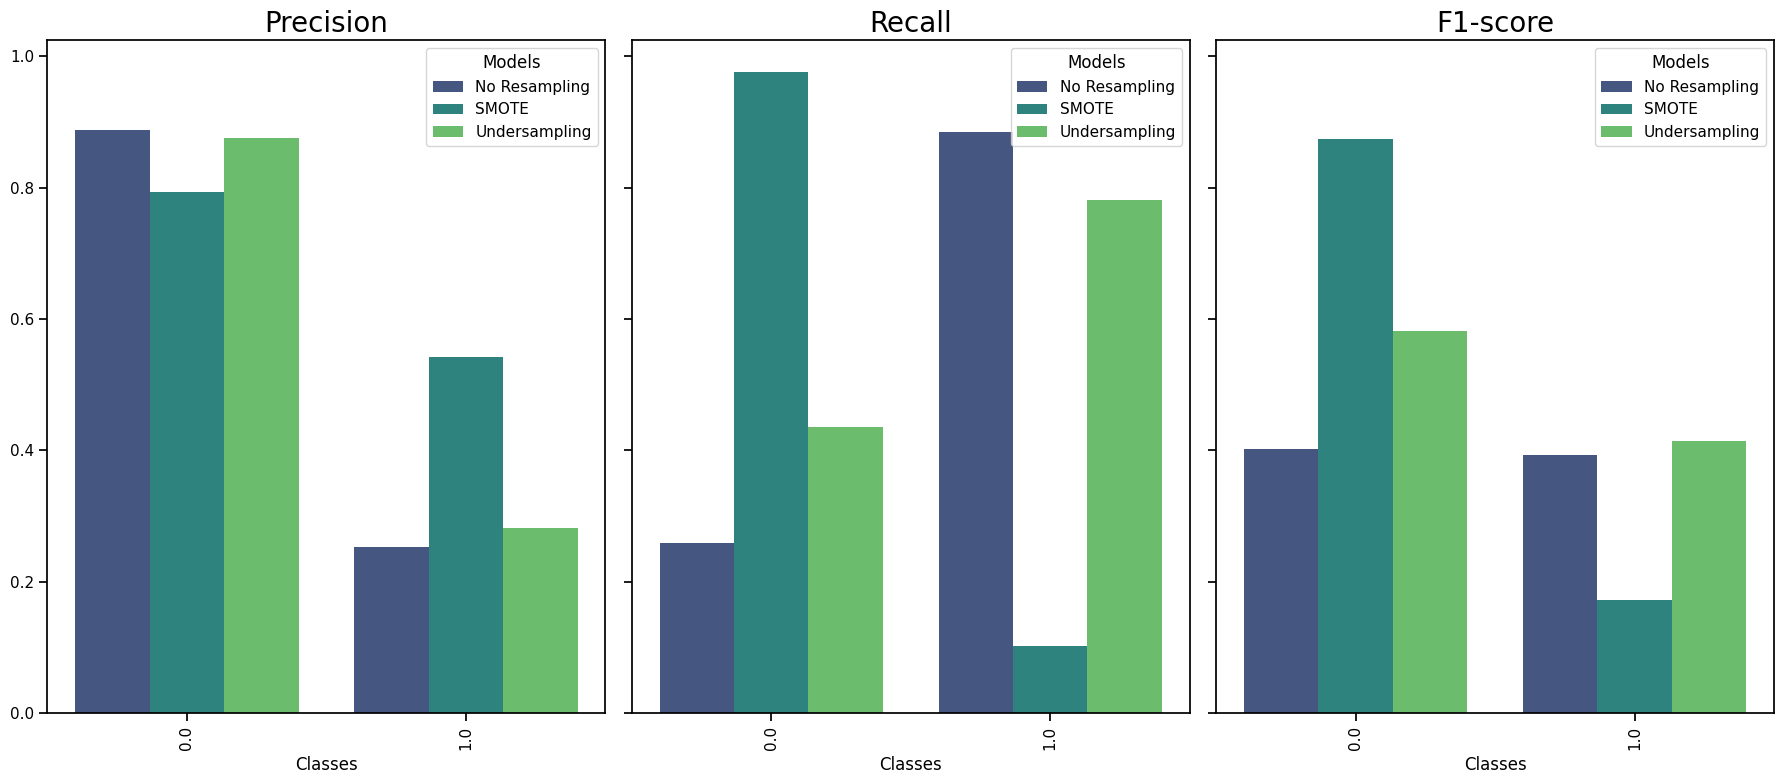

In [11]:
# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Convert data to tensors
X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)

# Train and evaluate model without any resampling
report_no_resampling, y_pred_no_resampling = train_and_evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Apply SMOTE and evaluate
X_train_smote, y_train_smote = apply_smote(X_train, y_train)
X_train_smote_tensor, y_train_smote_tensor = convert_to_tensors(X_train_smote, y_train_smote)
report_smote, y_pred_smote = train_and_evaluate_model(X_train_smote_tensor, y_train_smote_tensor, X_test_tensor, y_test_tensor)
# plot_class_distribution_after_sampling(y_train_smote, "SMOTE")

# Apply undersampling and evaluate
X_train_under, y_train_under = apply_undersampling(X_train, y_train)
X_train_under_tensor, y_train_under_tensor = convert_to_tensors(X_train_under, y_train_under)
report_under, y_pred_under = train_and_evaluate_model(X_train_under_tensor, y_train_under_tensor, X_test_tensor, y_test_tensor)
# plot_class_distribution_after_sampling(y_train_under, "Undersampling")

# Collect reports and predictions
y_trues = [y_test_tensor, y_test_tensor, y_test_tensor]
y_preds = [y_pred_no_resampling, y_pred_smote, y_pred_under]
model_names = ['No Resampling', 'SMOTE', 'Undersampling']

# Plot multiple classification reports
plot_multiple_classification_reports(y_trues, y_preds, model_names)


#### Visualize Class Imbalance





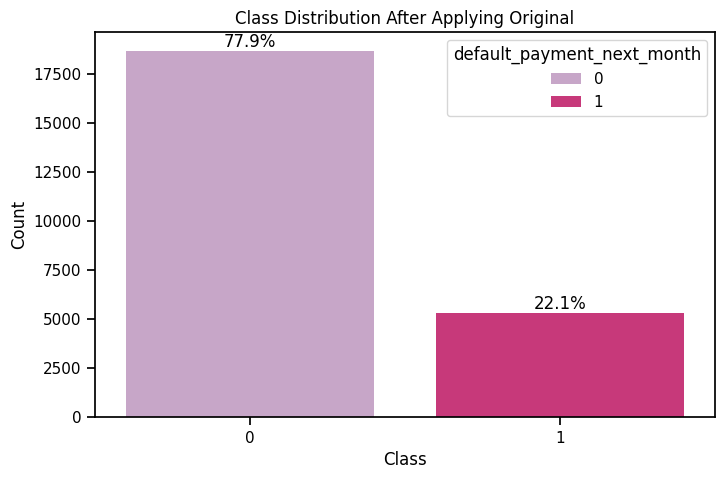

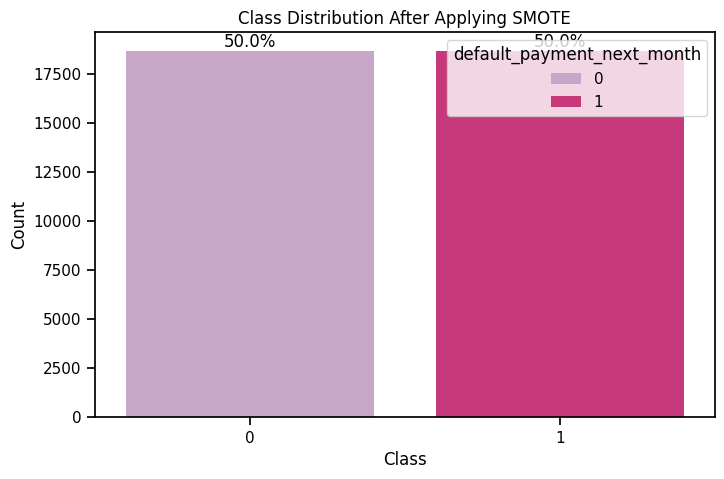

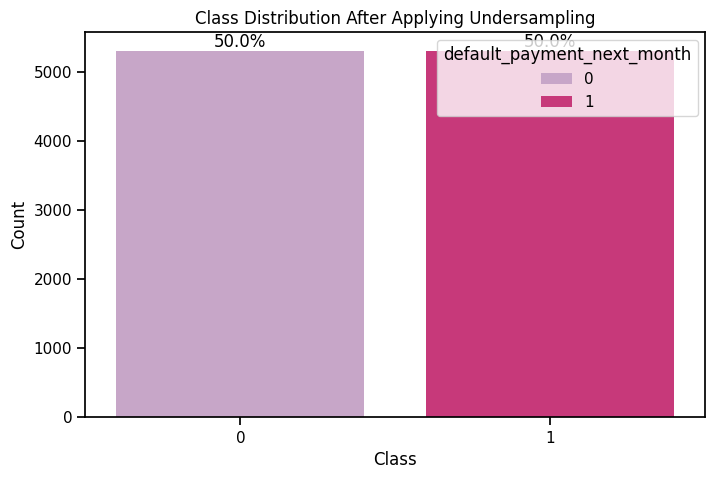

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

plot_class_distribution_after_sampling(y_train, "Original")
plot_class_distribution_after_sampling(y_train_smote, "SMOTE")
plot_class_distribution_after_sampling(y_train_under, "Undersampling")

#SMOTE

### Visualize Distribution after Resampling

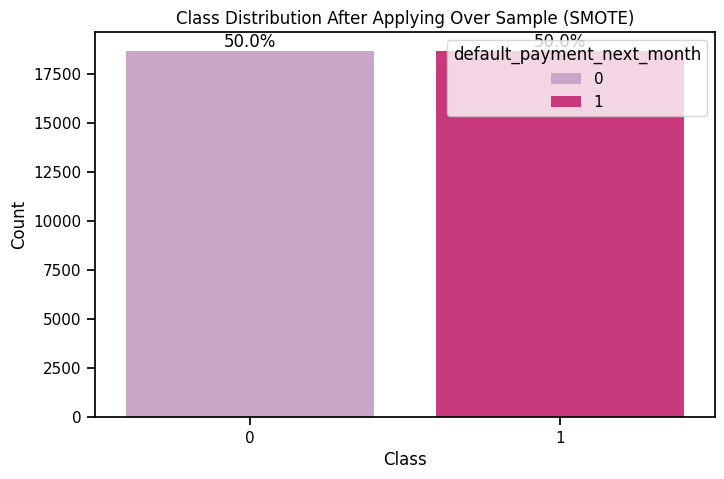

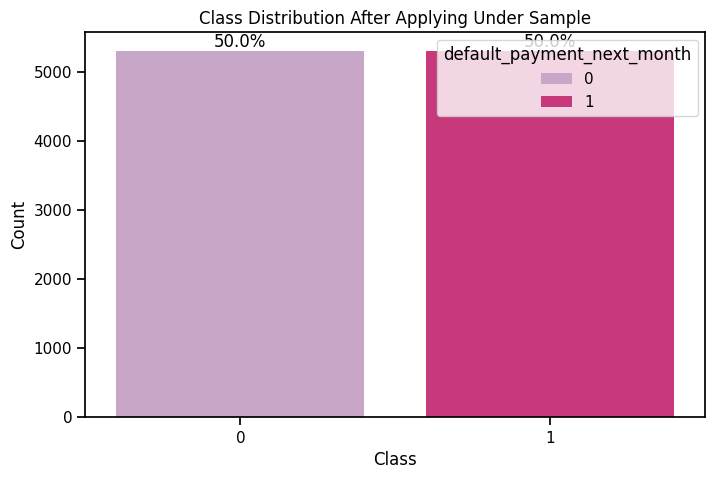

In [8]:
# Apply Oversampling with SMOTE
X_train_res, y_train_res = apply_smote(X_train, y_train)

# Plot class distribution after SMOTE
plot_class_distribution_after_sampling(y_train_res, 'Over Sample (SMOTE)')

# Apply Undersampling
X_train_under, y_train_under = apply_undersampling(X_train, y_train)

# Plot class distribution after undersampling
plot_class_distribution_after_sampling(y_train_under, 'Under Sample')


<Figure size 1200x800 with 0 Axes>

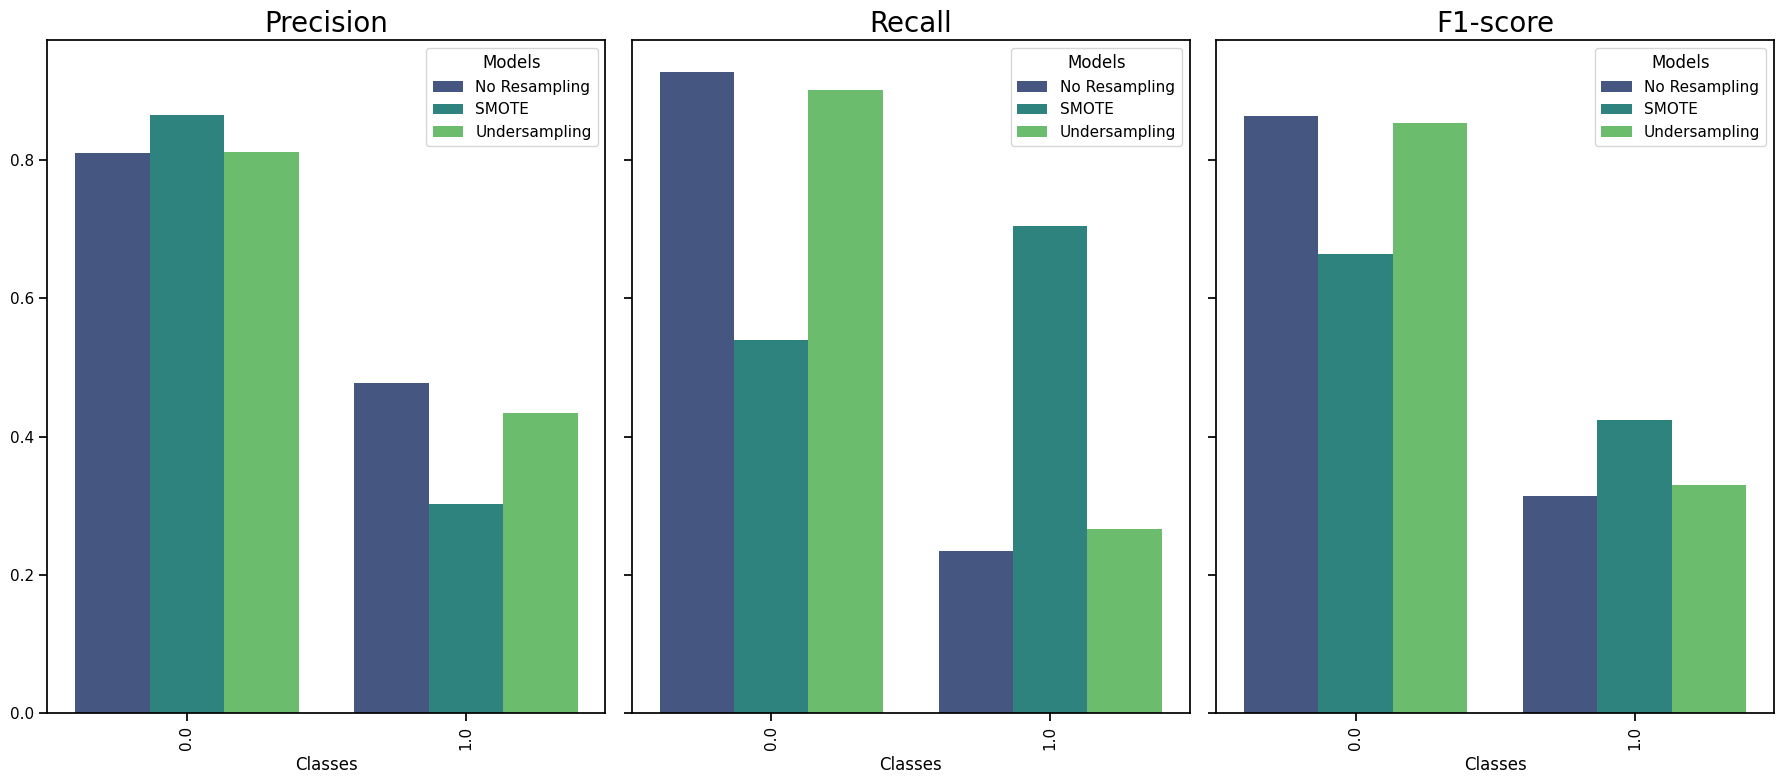

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from model_pipeline import SklearnSimpleNN, train_model
import torch

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    input_dim = X_train.shape[1]
    if class_weights is None:
        class_weights = [1.0, 1.0]

    nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train, y_train)
    y_pred = nn_estimator.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

# Function to plot multiple classification reports
def plot_multiple_classification_reports(y_trues, y_preds, model_names, metrics=['precision', 'recall', 'f1-score'], palette="viridis"):
    reports = []
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        # Generate classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        # Drop the non-class rows
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
        report_df['model'] = model_name
        reports.append(report_df)

    # Combine all reports into a single DataFrame
    combined_report = pd.concat(reports).reset_index().rename(columns={'index': 'class'})

    # Plot the results for each metric
    sns.set_context('notebook')
    plt.figure(figsize=(10,7))
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=combined_report, x='class', y=metric, hue='model', palette=palette, ax=ax)
        ax.set_title(f'{metric.capitalize()}', fontsize=20)
        ax.set_xlabel('Classes')
        # ax.set_ylabel(metric.capitalize())
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title='Models', loc='upper right')

    plt.tight_layout()
    plt.show()

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Convert data to tensors
X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)

# Train and evaluate model without any resampling
report_no_resampling, y_pred_no_resampling = train_and_evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Apply SMOTE and evaluate
X_train_smote, y_train_smote = apply_smote(X_train, y_train)
X_train_smote_tensor, y_train_smote_tensor = convert_to_tensors(X_train_smote, y_train_smote)
report_smote, y_pred_smote = train_and_evaluate_model(X_train_smote_tensor, y_train_smote_tensor, X_test_tensor, y_test_tensor)

# Apply undersampling and evaluate
X_train_under, y_train_under = apply_undersampling(X_train, y_train)
X_train_under_tensor, y_train_under_tensor = convert_to_tensors(X_train_under, y_train_under)
report_under, y_pred_under = train_and_evaluate_model(X_train_under_tensor, y_train_under_tensor, X_test_tensor, y_test_tensor)

# Collect reports and predictions
y_trues = [y_test_tensor, y_test_tensor, y_test_tensor]
y_preds = [y_pred_no_resampling, y_pred_smote, y_pred_under]
model_names = ['No Resampling', 'SMOTE', 'Undersampling']

# Plot multiple classification reports
plot_multiple_classification_reports(y_trues, y_preds, model_names)


In [3]:
# Reload the module
import importlib
import model_pipeline
importlib.reload(model_pipeline)

<module 'model_pipeline' from '/content/model_pipeline.py'>

In [5]:
plot_class_distribution_after_smote(y_train_smote)

NameError: name 'plot_class_distribution_after_smote' is not defined

In [6]:
plot_class_distribution_after_smote(y_train_under)

NameError: name 'plot_class_distribution_after_smote' is not defined

In the context of fraud detection, **recall (sensitivity)** is generally considered more important than precision. Here’s why:

### Importance of Recall in Fraud Detection

1. **High Cost of Missing Fraudulent Transactions**:
   - In fraud detection, the primary goal is to identify as many fraudulent transactions as possible. Missing a fraudulent transaction (false negative) can lead to significant financial losses and potential reputational damage. Therefore, having a high recall ensures that most fraudulent transactions are detected.

2. **Accepting Some False Positives**:
   - While false positives (legitimate transactions flagged as fraudulent) can be inconvenient and may require additional verification steps, the consequences are typically less severe than missing a fraudulent transaction. Companies can manually review flagged transactions to confirm their legitimacy, which is a manageable process.

3. **Safety Net**:
   - Ensuring that most fraud cases are caught, even at the expense of some false alarms, provides a safety net that is crucial for protecting financial assets and maintaining customer trust.

### Balancing Precision and Recall

However, it’s important to find a balance that suits the specific context and resources available. Excessive false positives can lead to customer dissatisfaction and increased operational costs due to manual reviews. Therefore, while recall is prioritized, precision should not be completely disregarded.

### Practical Approach in Fraud Detection

1. **Adjusting the Threshold**:
   - As mentioned earlier, adjusting the decision threshold can help balance recall and precision. Lowering the threshold increases recall but may reduce precision.

2. **Using Evaluation Metrics**:
   - **F1 Score**: The F1 score, which is the harmonic mean of precision and recall, can be a useful metric to find a balance. However, if recall is the priority, you might focus more on maximizing recall even if the F1 score is slightly lower.

3. **Implementing Resampling Techniques**:
   - Techniques like SMOTE or balanced random forests can help improve model performance on the minority class.

4. **Post-Processing**:
   - Implementing rules or secondary models to review flagged transactions can help manage false positives. For example, flagging transactions for manual review if they fall into a certain range of probabilities.




The order of operations in your workflow is crucial and can significantly affect the outcomes. Let's break down the proper sequence of steps for handling imbalanced data and finding optimal thresholds and weights:

1. **Apply SMOTE**:
   - **Purpose**: To balance the dataset by generating synthetic samples for the minority class.
   - **When to Apply**: Before determining class weights and before training the model.

2. **Determine Class Weights**:
   - **Purpose**: To handle class imbalance by assigning higher weights to the minority class.
   - **When to Apply**: After applying SMOTE but before training the model.

3. **Train the Model**:
   - **Purpose**: To learn from the balanced dataset.
   - **When to Apply**: After applying SMOTE and determining class weights.

4. **Determine Optimal Threshold**:
   - **Purpose**: To find the best decision threshold for the model to optimize the desired metric (e.g., recall).
   - **When to Apply**: After training the model.

### Correct Sequence of Operations

1. **Apply SMOTE** to the training data.
2. **Determine Class Weights** based on the resampled data.
3. **Train the Model** using the resampled data and class weights.
4. **Determine Optimal Threshold** for the model predictions.



In [ ]:
import numpy as np
import torch
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data, calculate_class_weights, SklearnSimpleNN, train_model, evaluate_model

# Function to apply SMOTE and convert to tensors
def apply_smote_and_convert_to_tensors(X_train_processed, y_train):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

    # Convert resampled data to tensors
    X_train_tensor_res = torch.tensor(X_train_res, dtype=torch.float32)
    y_train_tensor_res = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)

    return X_train_tensor_res, y_train_tensor_res, y_train_res

# Function to evaluate model performance at different thresholds, prioritizing recall
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    best_recall = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, f1, precision, recall))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    print(f"Best Threshold for Recall: {best_threshold:.2f}, Best Recall: {best_recall:.4f}")
    return results

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_test_tensor, y_prob):
    precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Function to run the full pipeline with SMOTE
def run_full_pipeline_with_smote(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    # Apply SMOTE and convert to tensors
    X_train_tensor_res, y_train_tensor_res, y_train_res = apply_smote_and_convert_to_tensors(X_train_processed, y_train)

    # Calculate class weights
    class_weights = calculate_class_weights(y_train_res)

    # Train and evaluate the model
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor_res.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor_res, y_train_tensor_res)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

    # Predict probabilities on the test set
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

    return y_prob, y_test_tensor

# Define the main function to evaluate thresholds
def evaluate_model_with_smote(url, categorical_columns, target):
    y_prob, y_test_tensor = run_full_pipeline_with_smote(url, categorical_columns, target)

    # Define a range of thresholds to evaluate
    thresholds = np.arange(0.1, 0.9, 0.1)

    # Evaluate and print the results for each threshold
    results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test_tensor, y_prob)

if __name__ == "__main__":
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    categorical_columns = ['sex', 'education', 'marriage']
    target = 'default_payment_next_month'
    evaluate_model_with_smote(url, categorical_columns, target)


In [ ]:
# Define the content for imbalanced_data_utils.py
imbalanced_utils_content = """

import numpy as np
import torch
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data, calculate_class_weights, SklearnSimpleNN, train_model, evaluate_model

# Function to apply SMOTE and convert to tensors
def apply_smote_and_convert_to_tensors(X_train_processed, y_train):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

    # Convert resampled data to tensors
    X_train_tensor_res = torch.tensor(X_train_res, dtype=torch.float32)
    y_train_tensor_res = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)

    return X_train_tensor_res, y_train_tensor_res, y_train_res

# Function to evaluate model performance at different thresholds, prioritizing recall
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    best_recall = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, f1, precision, recall))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    print(f"Best Threshold for Recall: {best_threshold:.2f}, Best Recall: {best_recall:.4f}")
    return results

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_test_tensor, y_prob):
    precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Function to run the full pipeline with SMOTE
def run_full_pipeline_with_smote(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    # Apply SMOTE and convert to tensors
    X_train_tensor_res, y_train_tensor_res, y_train_res = apply_smote_and_convert_to_tensors(X_train_processed, y_train)

    # Calculate class weights
    class_weights = calculate_class_weights(y_train_res)

    # Train and evaluate the model
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor_res.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor_res, y_train_tensor_res)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

    # Predict probabilities on the test set
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

    return y_prob, y_test_tensor

# Define the main function to evaluate thresholds
def evaluate_model_with_smote(url, categorical_columns, target):
    y_prob, y_test_tensor = run_full_pipeline_with_smote(url, categorical_columns, target)

    # Define a range of thresholds to evaluate
    thresholds = np.arange(0.1, 0.9, 0.1)

    # Evaluate and print the results for each threshold
    results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test_tensor, y_prob)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Evaluate model with SMOTE")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")

    args = parser.parse_args()

    evaluate_model_with_smote(args.url, args.categorical_columns, args.target)


import numpy as np
import torch
from imbalanced_data_utils import evaluate_model_with_smote

# Define the main function
def main():
    import argparse

    parser = argparse.ArgumentParser(description="Evaluate model with SMOTE")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")

    args = parser.parse_args()

    evaluate_model_with_smote(args.url, args.categorical_columns, args.target)

if __name__ == "__main__":
    main()

"""

# Write the content to imbalanced_data_utils.py
with open("imbalanced_data_utils.py", "w") as file:
    file.write(imbalanced_utils_content)

print("imbalanced_data_utils.py created successfully")


In [ ]:
import numpy as np
import torch
from imbalanced_data_utils import evaluate_model_with_smote

# Assign variables
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the function
evaluate_model_with_smote(url, categorical_columns, target)
